# Introduction

The goal of this study is to investigate how Twitter, a popular social media platform, can be leveraged in detecting early risk of depression of its users. The study is inspired by [this article](https://time.com/1915/how-twitter-knows-when-youre-depressed/). 

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import re
%matplotlib inline

!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer

!pip install wordcloud
from wordcloud import WordCloud

!pip install tweet-preprocessor
import preprocessor as p

from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

  Stored in directory: /tmp/.cache/pip/wheels/1b/27/cc/49938e98a2470802ebdefae9d2b3f524768e970c1ebbe2dc4a
Successfully built tweet-preprocessor


Using TensorFlow backend.


In [2]:
data_dir = "../input"

In [3]:
!ls {data_dir}

depressive-tweets-processed  googles-trained-word2vec-model-in-python
english-contractions	     sentiment140


## Classification of depressive and normal tweets

### Datasets

For this analysis, the [Sentiment140](https://www.kaggle.com/kazanova/sentiment140) dataset is used. 

In [4]:
encoding = 'ISO-8859-1'
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']

dataset = pd.read_csv(os.path.join(data_dir, 'sentiment140/training.1600000.processed.noemoticon.csv'), encoding=encoding, names=col_names)

In [5]:
dataset.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


For this experiment, I took a random sample of 8000 tweets.

In [6]:
df = dataset.copy().sample(8000, random_state=42)
df["label"] = 0
df = df[['text', 'label']]
df.dropna(inplace=True)
df.head()

,text,label
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,0
750,"@misstoriblack cool , i have no tweet apps fo...",0
766711,@TiannaChaos i know just family drama. its la...,0
285055,School email won't open and I have geography ...,0
705995,upper airways problem,0


Since there is no readily available public dataset on depression, I found a dataset scraped by [Twint](https://github.com/twintproject/twint).  

In [7]:
col_names = ['id', 'text']
df2 = pd.read_csv(os.path.join(data_dir, 'depressive-tweets-processed/depressive_tweets_processed.csv'), sep = '|', header = None, usecols = [0,5], nrows = 3200, names=col_names)

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 2 columns):
id      2345 non-null object
text    2313 non-null object
dtypes: object(2)
memory usage: 36.7+ KB


In [9]:
# add `label` colum with value 1's
df2['label'] = 1
df2 = df2[['text', 'label']]

In [10]:
df = pd.concat([df,df2]) # merge the dataset on normal tweets and depressive tweets
df = df.sample(frac=1)  # shuffle the dataset

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10345 entries, 22943 to 697392
Data columns (total 2 columns):
text     10313 non-null object
label    10345 non-null int64
dtypes: int64(1), object(1)
memory usage: 242.5+ KB


### Preprocessing

In [12]:
contractions = pd.read_json(os.path.join(data_dir, 'english-contractions/contractions.json'), typ='series')
contractions = contractions.to_dict()

In [13]:
c_re = re.compile('(%s)' % '|'.join(contractions.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return contractions[match.group(0)]
    return c_re.sub(replace, text)

In [14]:
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        tweet = tweet.lower()
        tweet = BAD_SYMBOLS_RE.sub(' ', tweet)
        tweet = p.clean(tweet)
        
        #expand contraction
        tweet = expandContractions(tweet)

        #remove punctuation
        tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

        #stop words
        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet) 
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        tweet = ' '.join(filtered_sentence)
        
        cleaned_tweets.append(tweet)
        
    return cleaned_tweets

In [15]:
X = clean_tweets([tweet for tweet in df['text']])

## Word analysis

In [16]:
depressive_tweets = [clean_tweets([t for t in df2['text']])]
depressive_words = ' '.join(list(map(str, depressive_tweets)))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)

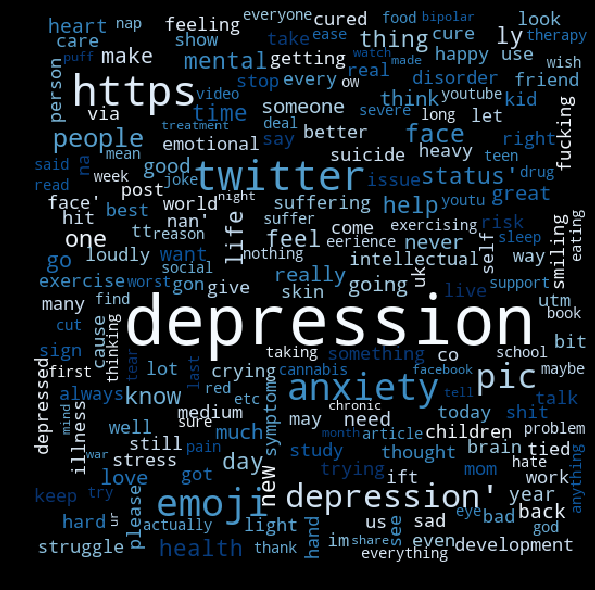

In [17]:
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

It's easy to spot words that are indicative of depression in these tweets: depression, treatment, suffering, crying, help, struggle, risk, hate, sad, anxiety, disorder, suicide, stress, therapy, mental health, emotional, bipolar.

### Tokenization

In [18]:
MAX_NUM_WORDS = 10000
tokenizer= Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)

In [19]:
word_vector = tokenizer.texts_to_sequences(X)

In [20]:
word_index = tokenizer.word_index

In [21]:
vocab_size = len(word_index)
vocab_size   # num of unique tokens

20652

In [22]:
MAX_SEQ_LENGTH = 140
input_tensor = pad_sequences(word_vector, maxlen=MAX_SEQ_LENGTH)

In [23]:
input_tensor.shape

(10345, 140)

## Baseline model

### TF-IDF classifier

In [24]:
corpus = df['text'].values.astype('U')
tfidf = TfidfVectorizer(max_features = MAX_NUM_WORDS) 
tdidf_tensor = tfidf.fit_transform(corpus)

In [25]:
tdidf_tensor.shape

(10345, 10000)

### Training

In [26]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(tdidf_tensor, df['label'].values, test_size=0.3)

In [27]:
baseline_model = SVC()
baseline_model.fit(x_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [28]:
predictions = baseline_model.predict(x_test)

In [29]:
accuracy_score(y_test, predictions)

0.7851159793814433

In [30]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.78512   1.00000   0.87962      2437
           1    0.00000   0.00000   0.00000       667

    accuracy                        0.78512      3104
   macro avg    0.39256   0.50000   0.43981      3104
weighted avg    0.61641   0.78512   0.69061      3104



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## LTSM model

Let's improve our model with LTSM. 

### Word embedding

In [ ]:
EMBEDDING_FILE = os.path.join(data_dir, 'googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin.gz')
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [ ]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

In [ ]:
for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NUM_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

### Training

In [ ]:
inp = Input(shape=(MAX_SEQ_LENGTH,))
x = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1, activation="sigmoid")(x)

In [ ]:
# Compile the model
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(input_tensor, df['label'].values, test_size=0.3)

In [ ]:
model.fit(x_train, y_train, batch_size=16, epochs=10)

In [ ]:
preds = model.predict(x_test)

In [ ]:
preds  = np.round(preds.flatten())
print(classification_report(y_test, preds, digits=5))

## Playing with other models

### Naive Baye's

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, df.label, test_size=0.3, random_state = 42)

In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [33]:
y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, digits=5))

accuracy 0.9081829896907216
              precision    recall  f1-score   support

           0    0.89393   1.00000   0.94400      2402
           1    1.00000   0.59402   0.74531       702

    accuracy                        0.90818      3104
   macro avg    0.94697   0.79701   0.84465      3104
weighted avg    0.91792   0.90818   0.89906      3104



## Linear Support Vector

In [34]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [35]:
y_pred = sgd.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, digits=5))

accuracy 0.9826030927835051
              precision    recall  f1-score   support

           0    0.97840   0.99958   0.98888      2402
           1    0.99846   0.92450   0.96006       702

    accuracy                        0.98260      3104
   macro avg    0.98843   0.96204   0.97447      3104
weighted avg    0.98294   0.98260   0.98236      3104



## Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(x_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [37]:
y_pred = logreg.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, digits=5))

accuracy 0.9503865979381443
              precision    recall  f1-score   support

           0    0.97547   0.96003   0.96769      2402
           1    0.87027   0.91738   0.89320       702

    accuracy                        0.95039      3104
   macro avg    0.92287   0.93871   0.93045      3104
weighted avg    0.95167   0.95039   0.95084      3104

